In [1]:
"""
Description: Script to optimize Duca's currency mix.
Author: Jeroen van Dijk & Victor de Graaff
Date: 04-11-2020
Maintainer: Jeroen van Dijk & Victor de Graaff
Email: jeroen.vandijk@d-data.nl & victor.degraaff@d-data.nl
Status: Dev
"""

"\nDescription: Script to optimize Duca's currency mix.\nAuthor: Jeroen van Dijk & Victor de Graaff\nDate: 04-11-2020\nMaintainer: Jeroen van Dijk & Victor de Graaff\nEmail: jeroen.vandijk@d-data.nl & victor.degraaff@d-data.nl\nStatus: Dev\n"

In [80]:
# Load common imports
%run ./CommonImports.ipynb

In [81]:
# Load common functions and currencies lists:
# - all_currencies
# - obsolete_currencies
# - p13_currencies
# - f_currencies
# - ff_currencies
# - currencies_per_continent
%run ./Utilities.ipynb

In [82]:
# Load loss functions
# - calculate_loss_function_around_one(weights)
# - calculate_loss_function_vs_t_minus_one(weights)
# - calculate_loss_function_vs_t_minus_one_with_balancing(weights)
# - calculate_loss_function_vs_t_minus_one_for_period(weights, max_date)
%run ./LossFunctions.ipynb

In [5]:
# Create dataframe with pre-defined base currency
df = create_original_df("EUR")

In [6]:
# Determine splits for dev- (train and test) and validation set
train_start = date(2005, 4, 1)
test_start = date(2012, 1, 1)
validation_start = date(2015, 1, 1)
validation_end = date(2020, 10, 1)

# Create dev (train and test) and validation set
train, test, dev, val = split_data(df, train_start, test_start, validation_start, validation_end)

In [7]:
# Create initial loss function values,
# to find find most/least stable currencies
results = pd.DataFrame()

# Calculate loss function score per currency
for base_currency in all_currencies:
    for currency in all_currencies:
        if currency == base_currency:
            continue
            
        rates = dev[base_currency] / dev[currency]
        normalized_rates = rates / rates.iloc[0]
        
        deviation = np.log(normalized_rates)
        loss_function_score = (deviation**2).mean()

        results = results.append({"currency": currency,
                                  "base_currency": base_currency,
                                  "loss_function_score": loss_function_score},
                                 ignore_index=True)
    
results = results.groupby("currency").median()
results.sort_values("loss_function_score", ascending=True)

,loss_function_score
currency,
CAD,0.015
MYR,0.016
NOK,0.017
HRK,0.020
SEK,0.020
CZK,0.021
EUR,0.021
DKK,0.021
USD,0.021


In [8]:
# Create exchange table for each currency
exchange_table = dict()
for base_currency in all_currencies:
    exchange_table[base_currency] = 1/train[all_currencies].divide(train[base_currency], axis=0)

# Preview USD exchange table
exchange_table["USD"]

,SEK,TRY,PHP,SGD,DKK,JPY,CNY,EUR,RUB,HUF,THB,ZAR,CAD,PLN,HRK,HKD,NZD,CZK,USD,CHF,KRW,GBP,NOK,IDR,MYR,AUD,RON
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-04-01,0.141,0.740,0.018,0.604,0.174,0.009,0.121,1.296,0.036,0.005,0.026,0.162,0.824,0.317,0.175,0.128,0.711,0.043,1.0,0.835,9.923e-04,1.887,0.158,1.056e-04,0.263,0.771,0.360
2005-04-02,0.141,0.738,0.018,0.603,0.174,0.009,0.121,1.293,0.036,0.005,0.025,0.162,0.823,0.316,0.174,0.128,0.709,0.043,1.0,0.833,9.904e-04,1.883,0.158,1.055e-04,0.263,0.770,0.359
2005-04-03,0.141,0.736,0.018,0.602,0.173,0.009,0.121,1.291,0.036,0.005,0.025,0.161,0.822,0.315,0.174,0.128,0.708,0.043,1.0,0.831,9.886e-04,1.879,0.157,1.055e-04,0.263,0.769,0.358
2005-04-04,0.140,0.733,0.018,0.600,0.173,0.009,0.121,1.288,0.036,0.005,0.025,0.161,0.821,0.313,0.174,0.128,0.707,0.043,1.0,0.829,9.867e-04,1.875,0.157,1.054e-04,0.263,0.768,0.358
2005-04-05,0.140,0.731,0.018,0.601,0.172,0.009,0.121,1.281,0.036,0.005,0.025,0.160,0.817,0.310,0.173,0.128,0.704,0.043,1.0,0.824,9.828e-04,1.873,0.157,1.053e-04,0.263,0.764,0.356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-27,0.146,0.526,0.023,0.771,0.176,0.013,0.158,1.307,0.032,0.004,0.032,0.123,0.981,0.297,0.174,0.129,0.774,0.051,1.0,1.070,8.652e-04,1.568,0.168,1.086e-04,0.315,1.016,0.305
2011-12-28,0.146,0.526,0.023,0.772,0.176,0.013,0.158,1.307,0.032,0.004,0.032,0.123,0.985,0.297,0.174,0.129,0.778,0.051,1.0,1.072,8.651e-04,1.567,0.168,1.087e-04,0.316,1.020,0.305
2011-12-29,0.144,0.523,0.023,0.767,0.173,0.013,0.158,1.289,0.031,0.004,0.031,0.123,0.977,0.290,0.171,0.129,0.767,0.050,1.0,1.058,8.658e-04,1.542,0.166,1.087e-04,0.315,1.007,0.300


In [126]:
this_day_by_month = {}
previous_day_by_month = {}
diff_by_month = defaultdict(dict)

for base_currency, table in exchange_table.items():
    if base_currency not in all_currencies:
        continue
        
    exchange_table[base_currency]["month"] = exchange_table[base_currency].index.map(lambda x: int(x.strftime("%Y%m")))

    this_day = exchange_table[base_currency]
    previous_day = pd.DataFrame(exchange_table[base_currency].shift(1), 
                                index=exchange_table[base_currency].index)
    previous_day["month"] = previous_day.index.map(lambda x: int(x.strftime("%Y%m")))
    
    this_day_by_month[base_currency] = {month: values[all_currencies] for month, values in this_day.groupby("month")}
    previous_day_by_month[base_currency] = {month: values[all_currencies] for month, values in previous_day.groupby("month")}
    
    for month in this_day_by_month[base_currency].keys():
        diff_by_month[base_currency][month] = np.abs((this_day_by_month[base_currency][month] - previous_day_by_month[base_currency][month]) / 
                                                      previous_day_by_month[base_currency][month])
    
months = list(exchange_table["EUR"]["month"].unique())

reference_date_exhange_rate = train[all_currencies].iloc[0]

In [13]:
if False:
    # Useful, but takes very long to run
    duca_mix_lf_values, libra_mix_lf_values, sdr_mix_lf_values, baseline_lf_values = [], [], [], []

    for selected_date in train.index:
        duca_mix_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(duca_mix, selected_date)]
        libra_mix_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(get_libra_mix(reference_date_exhange_rate.loc[p13_currencies]), selected_date)]
        sdr_mix_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(get_sdr_mix(reference_date_exhange_rate.loc[p13_currencies]), selected_date)]
        baseline_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(np.ones(13)/13, selected_date)]

    plt.plot(train.index, duca_mix_lf_values, label="Duca")
    plt.plot(train.index, libra_mix_lf_values, label="Libra")
    plt.plot(train.index, baseline_lf_values, label="Baseline")
    plt.plot(train.index, sdr_mix_lf_values, label="SDR")
    
    plt.legend()

In [ ]:
# Start with even playing field
# starting_point = np.ones(len(currencies))/len(currencies)
# USD    0.087
# EUR    0.099
# GBP    0.080
# CHF    0.060
# CNY    0.056
# JPY    0.071
# CAD    0.077
# SEK    0.073
# NOK    0.066
# SGD    0.071
# AUD    0.093
# NZD    0.074
# ZAR    0.094
# 0.17275234458598143

# Start with USD only
# starting_point = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# USD    0.108
# EUR    0.106
# GBP    0.067
# CHF    0.063
# CNY    0.039
# JPY    0.067
# CAD    0.082
# SEK    0.081
# NOK    0.056
# SGD    0.072
# AUD    0.095
# NZD    0.075
# ZAR    0.088
# 0.1727539055816972

# Start with all but ZAR
# starting_point = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
# USD    0.088
# EUR    0.087
# GBP    0.077
# CHF    0.066
# CNY    0.058
# JPY    0.072
# CAD    0.081
# SEK    0.076
# NOK    0.080
# SGD    0.064
# AUD    0.084
# NZD    0.075
# ZAR    0.093
# 0.17275471022697475

# Start randomly
# np.random.seed(42)
# starting_point = np.array([np.random.rand() for _ in range(13)])
# USD    0.075
# EUR    0.100
# GBP    0.077
# CHF    0.053
# CNY    0.052
# JPY    0.074
# CAD    0.075
# SEK    0.072
# NOK    0.075
# SGD    0.091
# AUD    0.079
# NZD    0.079
# ZAR    0.099
# 0.17275405004452105

# result = minimize(calculate_loss_function, starting_point, options={"disp": True, "maxiter": 100})
# duca_mix = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.index)
# print(calculate_loss_function(duca_mix))
# duca_mix

### Volatility score per currency

In [14]:
# TODO: use the same system to score the loss function
# See: https://en.wikipedia.org/wiki/Volatility_(finance) 
#      header: Alternative measures of volatility
# 
# Idea: we want to reduce the upwards and downwards motions: to make it as stable as possible
# what about this approach? https://www.mdpi.com/1911-8074/12/2/54

volatilities = pd.DataFrame()

for base_currency in p13_currencies:
    df = create_original_df(base_currency)
    train = df.query("date >= @train_start and date < @test_start")

    for currency in p13_currencies:
        if currency == base_currency:
            continue
        # DONE: this is all based on the exchange rate with the EUR only, what if we sum all base currencies?
        volatilities = volatilities.append({"base_currency": base_currency,
                                            "currency": currency, 
                                            "volatility": np.abs((train[currency] - train[currency].shift(1))/train[currency]).mean()},
                                           ignore_index=True)

# summarize volatilities per currency (summed up per baseline currency)
volatilities.groupby("currency").sum().sort_values("volatility")

,volatility
currency,
SGD,0.039
EUR,0.039
GBP,0.044
CNY,0.045
USD,0.045
SEK,0.046
NOK,0.046
CHF,0.046
CAD,0.049


In [ ]:
# Run with all 27 sensible valuta:
# KRW    0.047
# HKD    0.052
# USD    0.040
# PLN    0.030
# THB    0.047
# EUR    0.035
# ZAR    0.041
# RON    0.022
# SEK    0.043
# AUD    0.038
# JPY    0.028
# DKK    0.037
# RUB    0.036
# CAD    0.042
# HRK    0.066
# CNY    0.018
# CHF    0.030
# GBP    0.033
# NOK    0.027
# MYR    0.045
# TRY    0.041
# PHP    0.019
# HUF    0.043
# NZD    0.038
# IDR    0.042
# CZK    0.040
# SGD    0.021

# (calculate_loss_function(duca_mix), 
#  calculate_loss_function(np.ones(len(duca_mix))/len(duca_mix)), 
#  calculate_loss_function(get_libra_mix(reference_date_exhange_rate)), 
#  calculate_loss_function(get_sdr_mix(reference_date_exhange_rate)))

#  0.33854436038561553,
#  0.3400650723585818,
#  0.3842956486350562,
#  0.37333119031548356



# Run with 13 initial valuta:
# USD    0.087
# EUR    0.099
# GBP    0.080
# CHF    0.060
# CNY    0.056
# JPY    0.071
# CAD    0.077
# SEK    0.073
# NOK    0.066
# SGD    0.071
# AUD    0.093
# NZD    0.074
# ZAR    0.094

# (calculate_loss_function(duca_mix), 
#  calculate_loss_function(np.ones(len(duca_mix))/len(duca_mix)), 
#  calculate_loss_function(get_libra_mix(reference_date_exhange_rate)), 
#  calculate_loss_function(get_sdr_mix(reference_date_exhange_rate)))

#  0.17275234458598143,
#  0.17356119062704128,
#  0.19408065329315338,
#  0.19287288245710466

### Compare different Duca currency baskets

In [15]:
# 1. Not balanced - Patrick 13 currency set
starting_point = np.ones(13)/13
bounds = [(0,1) for _ in range(len(starting_point))]
result = minimize(calculate_loss_function_vs_t_minus_one, starting_point, options={"disp": True, 
                                                                                   "maxiter": 100})
duca_mix_1 = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[p13_currencies].index)
print(calculate_loss_function_vs_t_minus_one(duca_mix_1))
duca_mix_1.sort_values(ascending=False)

Optimization terminated successfully.
         Current function value: 0.035071
         Iterations: 68
         Function evaluations: 1050
         Gradient evaluations: 75
0.03507095558894311


EUR    0.164
SGD    0.131
GBP    0.102
CNY    0.084
NOK    0.082
SEK    0.075
AUD    0.069
JPY    0.055
CAD    0.053
NZD    0.052
CHF    0.046
USD    0.045
ZAR    0.043
dtype: float64

In [35]:
# 2. Balanced - Patrick 13 currency set
starting_point = np.ones(13)/13
bounds = [(0,1) for _ in range(len(starting_point))]

result = minimize(calculate_loss_function_vs_t_minus_one_with_balancing, starting_point, p13_currencies, bounds=bounds, options={"disp": True, 
                                                                                                                 "maxiter": 2,
                                                                                                                 })
duca_mix_2 = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[p13_currencies].index)
print(calculate_loss_function_vs_t_minus_one_with_balancing(duca_mix_2, p13_currencies))
duca_mix_2.sort_values(ascending=False)

282.12877732491506


NZD    0.108
AUD    0.108
SGD    0.108
CAD    0.108
CHF    0.108
GBP    0.108
EUR    0.108
USD    0.108
NOK    0.052
CNY    0.043
SEK    0.041
ZAR    0.000
JPY    0.000
dtype: float64

In [36]:
# 3. Balanced - Forward selection currency set (final selection)
selected_currencies = ["SEK", "GBP", "EUR", 
                       "USD", "CHF", "CAD", 
                       "SGD", "AUD"]
starting_point = np.ones(len(selected_currencies))/len(selected_currencies)
bounds = [(0,1) for _ in range(len(starting_point))]
result = minimize(calculate_loss_function_vs_t_minus_one_with_balancing, starting_point, selected_currencies, bounds=bounds, options={"disp": True, 
                                                                                                                                      "maxiter": 2,
                                                                                                                 })
duca_mix_3 = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[selected_currencies].index)
print(calculate_loss_function_vs_t_minus_one_with_balancing(duca_mix_3, selected_currencies))
duca_mix_3.sort_values(ascending=False)

65.69106279144212


EUR    0.296
GBP    0.296
USD    0.140
CHF    0.120
CAD    0.087
SGD    0.062
AUD    0.000
SEK    0.000
dtype: float64

In [111]:
# 4. Balanced - Backward selection currency set (min. 8)
selected_currencies = ["NZD", "AUD", "CAD",
                       "SGD", "USD", "CHF",
                       "EUR", "GBP"]
starting_point = np.ones(len(selected_currencies))/len(selected_currencies)
bounds = [(0,1) for _ in range(len(starting_point))]
result = minimize(calculate_loss_function_vs_t_minus_one_with_balancing, starting_point, selected_currencies, bounds=bounds, options={"disp": True, 
                                                                                                                                      "maxiter": 2,
                                                                                                                 })
duca_mix_4 = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[selected_currencies].index)
print(calculate_loss_function_vs_t_minus_one_with_balancing(duca_mix_4, selected_currencies))
duca_mix_4.sort_values(ascending=False)

50.92810796847587


GBP    0.5
EUR    0.5
CHF    0.0
USD    0.0
SGD    0.0
CAD    0.0
AUD    0.0
NZD    0.0
dtype: float64

In [128]:
# 5. Balanced - free-floating currencies only
selected_currencies = ff_currencies
starting_point = np.ones(len(selected_currencies))/len(selected_currencies)
bounds = [(0,1) for _ in range(len(starting_point))]
result = minimize(calculate_loss_function_vs_t_minus_one_with_balancing, starting_point, selected_currencies, bounds=bounds, options={"disp": True, 
                                                                                                                                      "maxiter": 2,
                                                                                                                 })
duca_mix_5 = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[selected_currencies].index)
print(calculate_loss_function_vs_t_minus_one_with_balancing(duca_mix_5, selected_currencies))
duca_mix_5.sort_values(ascending=False)

152.04128351938618


USD    0.173
EUR    0.173
GBP    0.173
CAD    0.173
AUD    0.173
PLN    0.106
NOK    0.030
RUB    0.000
SEK    0.000
JPY    0.000
dtype: float64

In [132]:
# 6. Balanced - free-floating + floating currencies
selected_currencies = ff_currencies + f_currencies
starting_point = np.ones(len(selected_currencies))/len(selected_currencies)
bounds = [(0,1) for _ in range(len(starting_point))]
result = minimize(calculate_loss_function_vs_t_minus_one_with_balancing, starting_point, selected_currencies, bounds=bounds, options={"disp": True, 
                                                                                                                                      "maxiter": 2,
                                                                                                                 })
duca_mix_6 = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[selected_currencies].index)
print(calculate_loss_function_vs_t_minus_one_with_balancing(duca_mix_6, selected_currencies))
duca_mix_6.sort_values(ascending=False)

2972.8445429842536


TRY    0.066
RUB    0.066
CAD    0.066
NOK    0.066
PLN    0.066
SEK    0.066
GBP    0.066
EUR    0.066
USD    0.066
NZD    0.066
RON    0.066
ZAR    0.066
AUD    0.066
THB    0.058
PHP    0.054
JPY    0.028
HUF    0.000
IDR    0.000
KRW    0.000
dtype: float64

In [86]:
def plot_valuta_mix(weights, base_currency, currencies, label):
    amounts = weights/weights.sum() * reference_date_exhange_rate[currencies]
    amounts_through_time = amounts * exchange_table[base_currency]

    normalized_amounts_through_time = amounts_through_time.sum(axis=1) / reference_date_exhange_rate[base_currency]
    plt.plot(normalized_amounts_through_time, label=label)
    
# Function for plotting currency exchange rates in base currency
def plot_base_currency(dataset=dev, base_currency="EUR", plot_in_grey=False):
    plt.figure(figsize=(12, 8))
    plt.title(base_currency)
    
    for currency in p13_currencies:
        if currency == base_currency:
            continue
            
        rates = dataset[base_currency] / dataset[currency]
        normalized_rates = rates / rates.iloc[0]
        
        if plot_in_grey:
            plt.plot(normalized_rates, label=currency, color="grey")
        else:
            plt.plot(normalized_rates, label=currency)
    
    if not plot_in_grey:
        plt.legend()

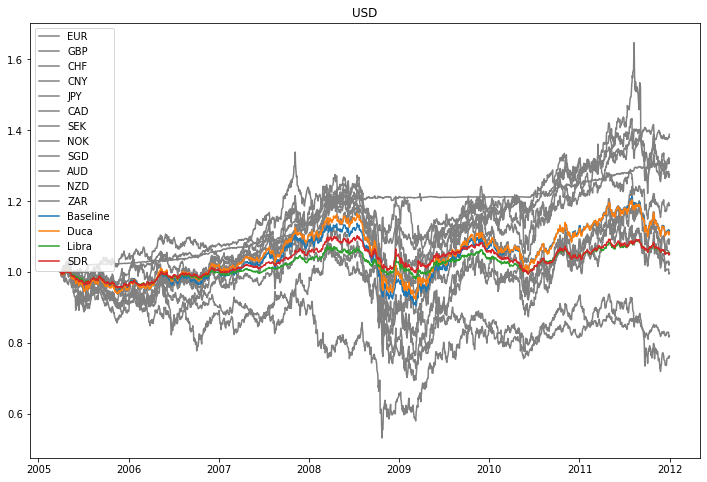

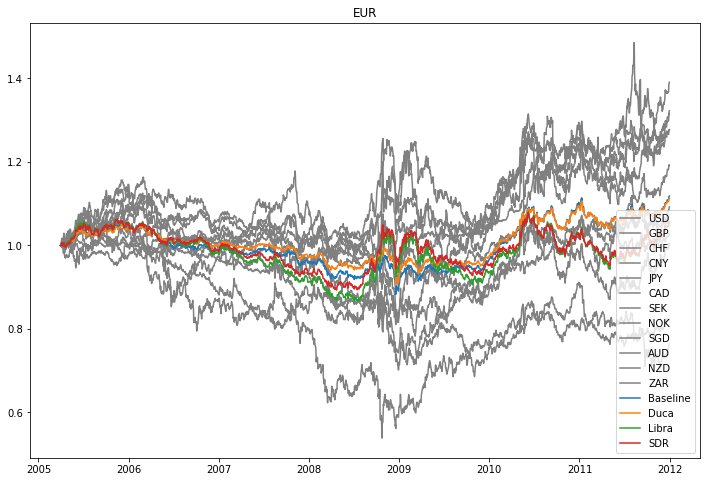

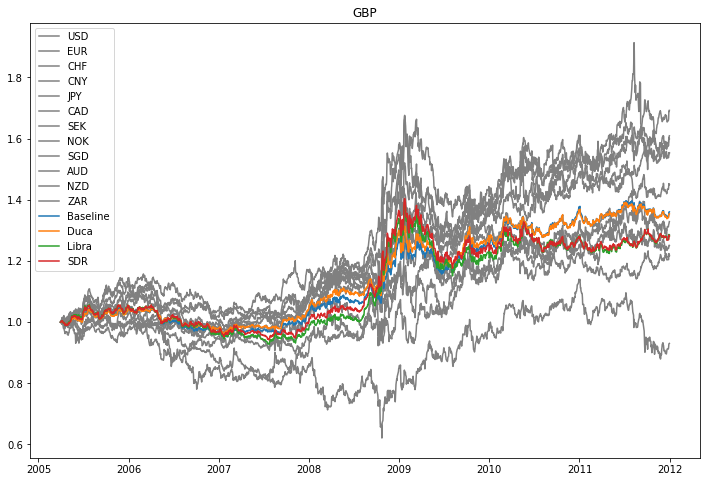

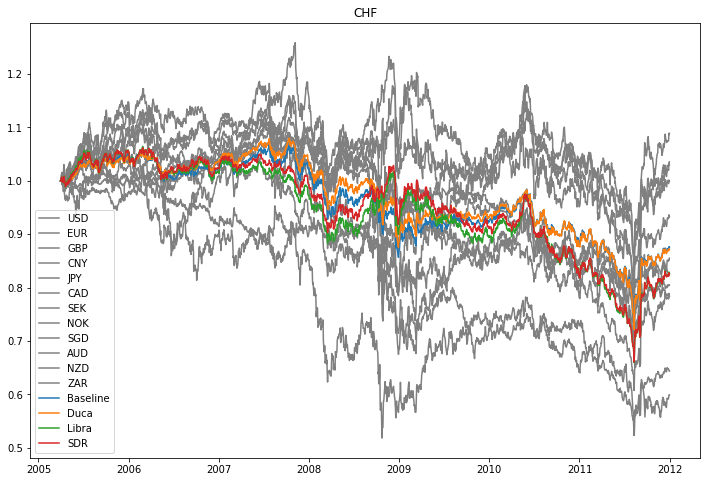

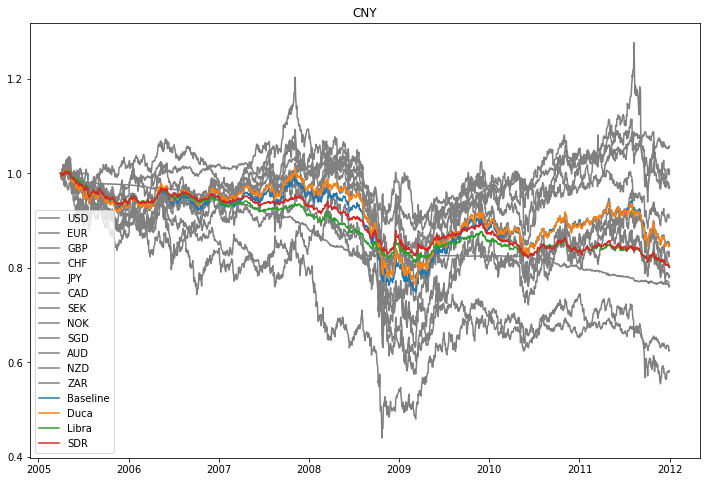

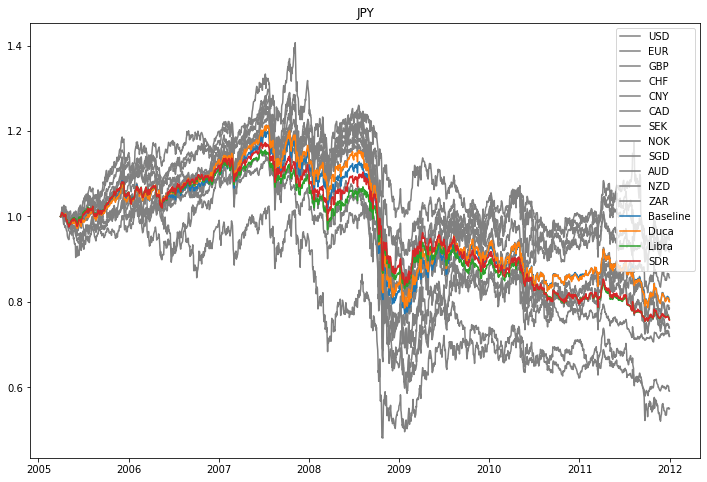

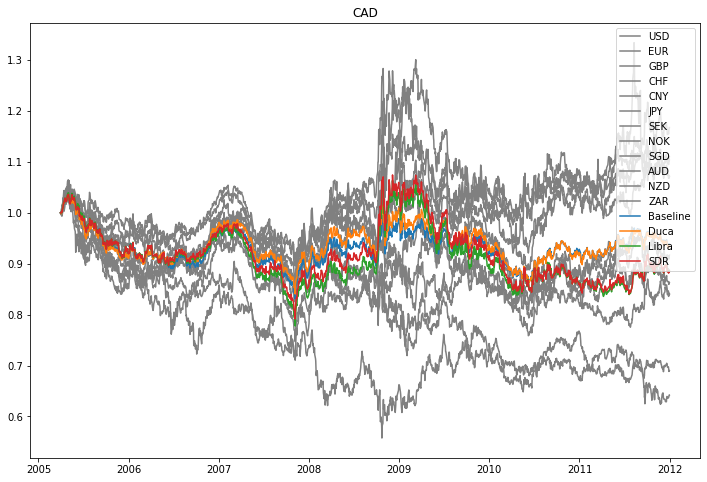

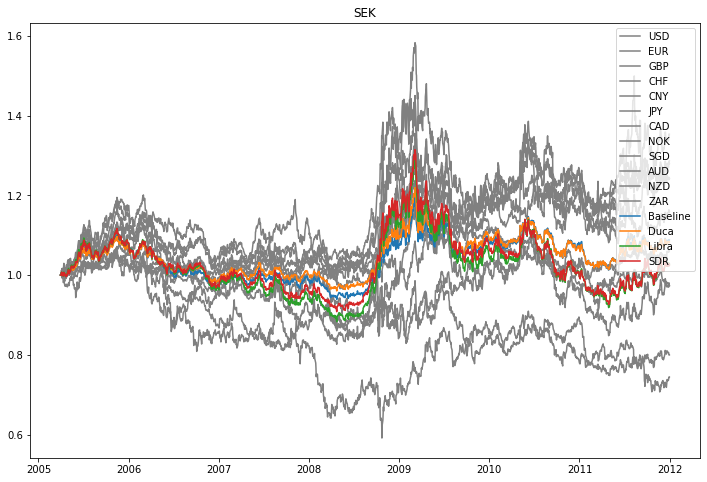

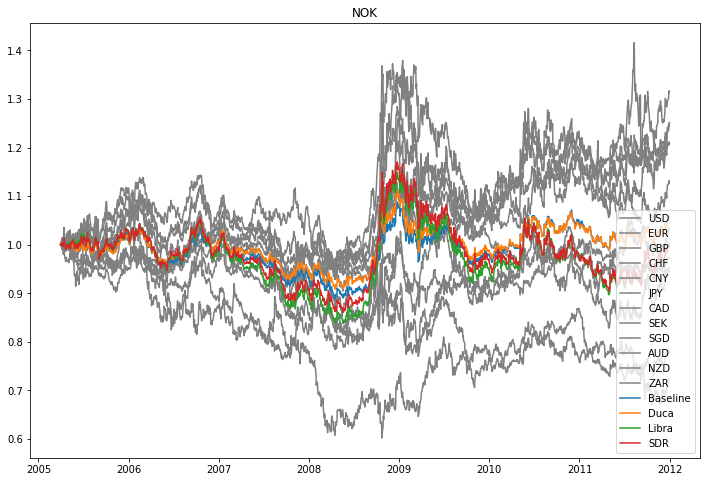

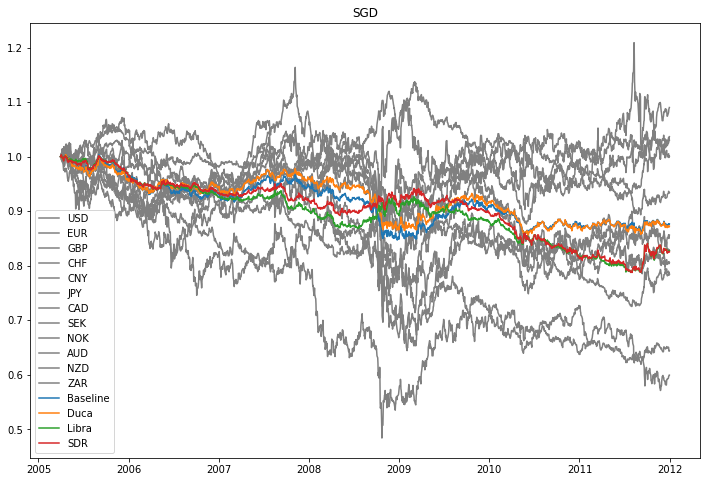

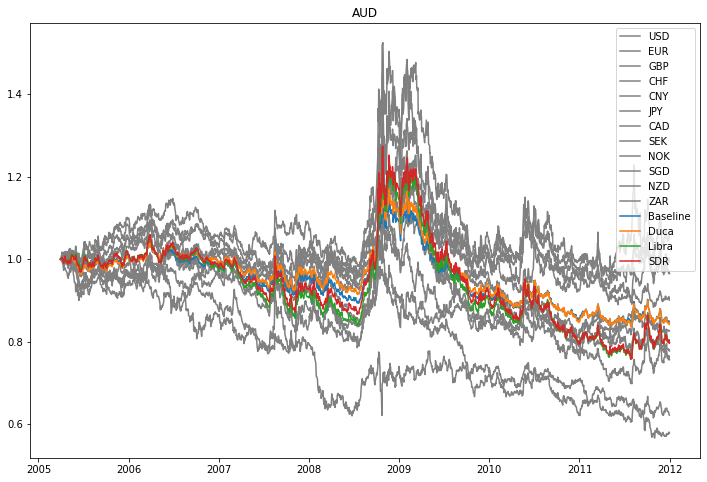

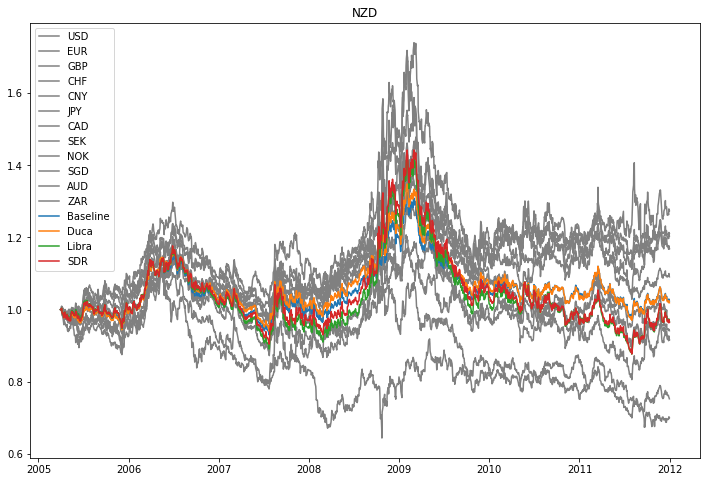

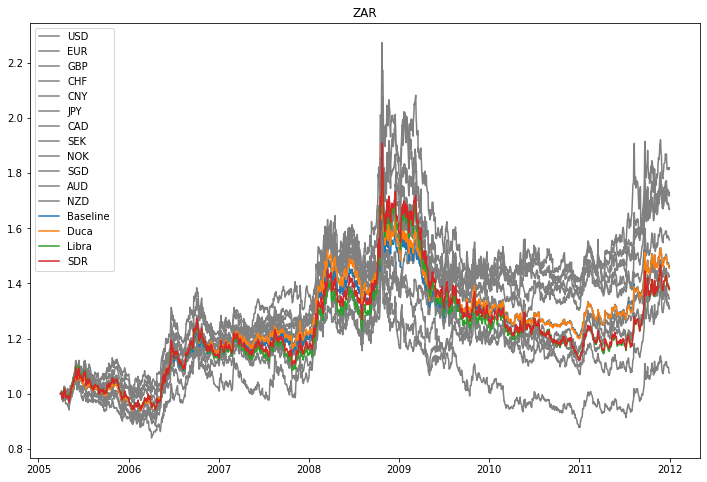

In [109]:
duca_mix = duca_mix_1
# duca_mix_1: not balanced - all currencies
# duca_mix_2: balanced - patrick's 13 currencies
# duca_mix_3: balanced forward selection
# duca_mix_4: balanced backward selection
# duca_mix_5: balanced free-floating only
# duca_mix_6: balanced free-floating & floating
currencies = list(duca_mix.index)

for base_currency in currencies:
    plot_base_currency(dataset=train, base_currency=base_currency, plot_in_grey=True)

    plot_valuta_mix(np.ones(len(currencies))/len(currencies), base_currency, currencies, "Baseline")
    plot_valuta_mix(duca_mix, base_currency, currencies, "Duca")
    plot_valuta_mix(get_libra_mix(currencies), base_currency, currencies, "Libra")
    plot_valuta_mix(get_sdr_mix(currencies), base_currency, currencies, "SDR")

    plt.legend()